# 50

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2023-05-29 05:23:11--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  10.3MB/s    in 2.7s    

2023-05-29 05:23:15 (10.3 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [ ]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換、'\''はエスケープされたシングルクオーテーション
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割,train,testの順に返す。stratifyで均等に分割したい要素を指定(多くは正解データ)
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])

# データの保存
train.to_csv('./train.txt', sep='\t', index=False)
valid.to_csv('./valid.txt', sep='\t', index=False)
test.to_csv('./test.txt', sep='\t', index=False)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())


# 51

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
nameoftrain = ""
corpus=[]

for index, tra in df.iterrows():
  corpus.append(tra['TITLE'])
vectorizer = TfidfVectorizer()#tfidfを用いた特徴量

vec = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
nameoftrain = feature_names
feature = pd.DataFrame(vec.toarray(), columns=feature_names)
display(feature)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def feature_value(t):
  corpus=[]

  for index, tra in t.iterrows():
    corpus.append(tra['TITLE'])
  vectorizer = TfidfVectorizer()#tfidfを用いた特徴量

  vec = vectorizer.fit_transform(corpus)
  feature_names = vectorizer.get_feature_names_out()
  feature = pd.DataFrame(vec.toarray(), columns=feature_names)
  for i in nameoftrain:
    if not(i in  feature_names):
      feature[i] = 0
  display(feature)
  feature = feature.sort_index(axis=1)
  return feature

In [ ]:
feature_value(train)

# 52

In [ ]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
# モデルの学習
feature=feature_value(train)
lg = LogisticRegression(random_state=123, max_iter=1000)
lg.fit(feature, train['CATEGORY'])

# 53

In [ ]:
X_test = feature_value(test)

In [ ]:
pred = lg.predict_proba(X_test) #ラベルの取得方法
print(pred)

# 54

In [ ]:
X_train = feature_value(train)

In [ ]:
pred_test=lg.predict(X_test)
pred_train=lg.predict(X_train)

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(pred_test, test['CATEGORY']))
print(accuracy_score(pred_train, train['CATEGORY']))

0.8937125748502994
0.9471171845750656


# 55

In [ ]:
from sklearn.metrics import confusion_matrix
con_test=confusion_matrix(y_true = test['CATEGORY'], y_pred = pred_test)
con_train=confusion_matrix(y_true = train['CATEGORY'], y_pred = pred_train)

print(con_test)
print(con_train)

# 56

In [ ]:
#適合率:正例と予測したもののうち、どれだけ正解だったか
#再現率:正解が正例のもののうち、どれだけ正例と予測できたか

tekigou_b=0
tekigou_e=0
tekigou_t=0
tekigou_m=0

saigen_b=0
saigen_e=0
saigen_t=0
saigen_m=0

tekigou_b=con_test[0][0]/(con_test[0][0]+con_test[1][0]+con_test[2][0]+con_test[3][0])
tekigou_e=con_test[1][1]/(con_test[0][1]+con_test[1][1]+con_test[2][1]+con_test[3][1])
tekigou_t=con_test[2][2]/(con_test[0][2]+con_test[1][2]+con_test[2][2]+con_test[3][2])
tekigou_m=con_test[3][3]/(con_test[0][3]+con_test[1][3]+con_test[2][3]+con_test[3][3])

print(tekigou_b, tekigou_e, tekigou_t, tekigou_m)

saigen_b=con_test[0][0]/(con_test[0][0]+con_test[0][1]+con_test[0][2]+con_test[0][3])
saigen_e=con_test[1][1]/(con_test[1][0]+con_test[1][1]+con_test[1][2]+con_test[1][3])
saigen_t=con_test[2][2]/(con_test[2][0]+con_test[2][1]+con_test[2][2]+con_test[2][3])
saigen_m=con_test[3][3]/(con_test[3][0]+con_test[3][1]+con_test[3][2]+con_test[3][3])




print(saigen_b, saigen_e, saigen_t, saigen_m)

0.9032258064516129 0.8815566835871405 0.9615384615384616 0.875
0.9449378330373002 0.9830188679245283 0.5494505494505495 0.5986842105263158


In [ ]:
F_b=(2*tekigou_b*saigen_b)/(saigen_b+tekigou_b)
F_e=(2*tekigou_e*saigen_e)/(saigen_e+tekigou_e)
F_t=(2*tekigou_t*saigen_t)/(saigen_t+tekigou_t)
F_m=(2*tekigou_m*saigen_m)/(saigen_m+tekigou_m)

print(F_b, F_e, F_t, F_m)

0.9236111111111112 0.9295272078501339 0.6993006993006995 0.7109375


In [ ]:
macro_tekigou=(tekigou_b+tekigou_e+tekigou_t+tekigou_m)/4
macro_saigen=(saigen_b+saigen_e+saigen_t+saigen_m)/4
macro_F=(F_b+F_e+F_t+F_m)/4
micro_tekigou=(con_test[0][0]+con_test[1][1]+con_test[2][2]+con_test[3][3])/(con_test[0][0]+con_test[1][0]+con_test[2][0]+con_test[3][0])+(con_test[0][1]+con_test[1][1]+con_test[2][1]+con_test[3][1])+(con_test[0][2]+con_test[1][2]+con_test[2][2]+con_test[3][2])+(con_test[0][3]+con_test[1][3]+con_test[2][3]+con_test[3][3])
micro_saigen=(con_test[0][0]+con_test[1][1]+con_test[2][2]+con_test[3][3])/(con_test[0][0]+con_test[0][1]+con_test[0][2]+con_test[0][3])+(con_test[1][0]+con_test[1][1]+con_test[1][2]+con_test[1][3])+(con_test[2][0]+con_test[2][1]+con_test[2][2]+con_test[2][3])+(con_test[3][0]+con_test[3][1]+con_test[3][2]+con_test[3][3])

print(macro_tekigou, macro_saigen, macro_F, micro_tekigou, micro_saigen)

0.9053302378943038 0.7690228652346736 0.8158441295654861 749.0271646859084 775.1207815275311


# 57

In [ ]:
import numpy as np

features = X_train.columns.values
index = [i for i in range(1, 11)]
for c, coef in zip(lg.classes_, lg.coef_):
  print(f'【カテゴリ】{c}')
  best10 = pd.DataFrame(features[np.argsort(coef)[::-1][:10]], columns=['重要度上位'], index=index).T
  worst10 = pd.DataFrame(features[np.argsort(coef)[:10]], columns=['重要度下位'], index=index).T
  display(pd.concat([best10, worst10], axis=0))
  print('\n')

# 58

In [ ]:
X_valid= feature_value(valid)

In [ ]:
from tqdm import tqdm
import numpy as np

result = []
for C in tqdm(np.logspace(-5, 4, 10, base=10)):
  # モデルの学習
  lg = LogisticRegression(random_state=123, max_iter=1000, C=C)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  train_pred = lg.predict(X_train)
  valid_pred = lg.predict(X_valid)
  test_pred = lg.predict(X_test)

  # 正解率の算出
  train_accuracy = accuracy_score(train['CATEGORY'], train_pred)
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred)
  test_accuracy = accuracy_score(test['CATEGORY'], test_pred)

  # 結果の格納
  result.append([C, train_accuracy, valid_accuracy, test_accuracy])

100%|██████████| 10/10 [25:42<00:00, 154.28s/it]


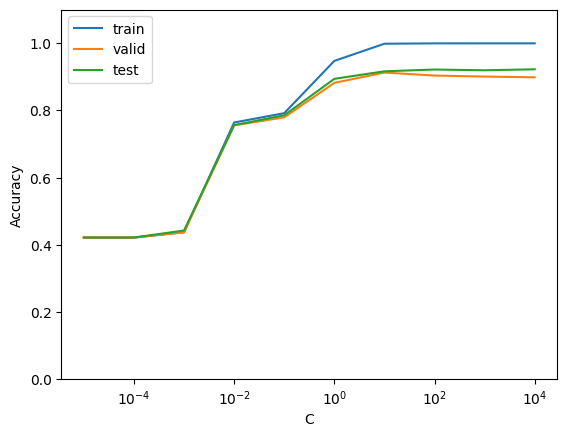

In [ ]:
# 視覚化
from matplotlib import pyplot as plt
result = np.array(result).T#便利、転置とる
plt.plot(result[0], result[1], label='train')
plt.plot(result[0], result[2], label='valid')
plt.plot(result[0], result[3], label='test')
plt.ylim(0, 1.1)
plt.ylabel('Accuracy')
plt.xscale ('log')
plt.xlabel('C')
plt.legend()
plt.show()

# 59

In [ ]:
max_c=100000000
max_true=-1
for c in np.logspace(-5, 5, 10, base=10):#Cの値を最適化する
  # モデルの学習
  lg = LogisticRegression(random_state=123, max_iter=1000, C=c)
  lg.fit(X_train, train['CATEGORY'])

  # 予測値の取得
  valid_pred = lg.predict(X_valid)

  # 正解率の算出
  valid_accuracy = accuracy_score(valid['CATEGORY'], valid_pred)
  if max_true < valid_accuracy:
    max_c=c

lg = LogisticRegression(random_state=123, max_iter=1000, C=max_c)
lg.fit(X_train, train['CATEGORY'])
test_pred=lg.predict(X_test)
test_accuracy = accuracy_score(test['CATEGORY'], test_pred)
print(test_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

0.9214071856287425
